
# SCPH Revised

**Contents**
1. Setup
    - 1.1 Environment
    - 1.2 Imports
    - 1.3 Settings and Parameters
2. Imports  
3. Settings (EOS, mesh, temps, toggles)  
4. Build structure & calculator  
5. Volume grid  
6. Per-volume phonons (with caching)  
7. Assemble & run QHA  
8. Plots (inline)  
9. Save/Load QHA data (CSV + pickle)


## 1. Setup

### 1.1. Environment

In [ ]:
#!pip -q install co2_potential hiphive phonopy pymatgen trainstation tqdm nglview spglib

In [6]:
import os
try:
    n_cores = len(os.sched_getaffinity(0))
except AttributeError:
    import multiprocessing as mp
    n_cores = mp.cpu_count()
print(n_cores)

10


### 1.2. Imports

In [1]:
import numpy as np, json, pickle
from pathlib import Path
from copy import deepcopy
from math import sqrt

from tqdm.auto import tqdm
from ase import units
from ase import Atoms
from ase.spacegroup import crystal
from ase.optimize import BFGS
#from ase.filters import 
#from ase.constraints import FixSymmetry, UnitCellFilter
#from ase.spacegroup.symmetrize import FixSymmetry

import ase
print("ase:", ase.__version__)

try:
    # ASE ≥ 3.24 usually re-exports FixSymmetry here
    from ase.filters import UnitCellFilter
    from ase.constraints import FixSymmetry
   
except ImportError:
    # Older ASE: FixSymmetry is in spacegroup.symmetrize
    #from ase.spacegroup.symmetrize import FixSymmetry
    #from ase.filters import FixSymmetry
    from ase.constraints import UnitCellFilter, FixSymmetry

import spglib
import phonopy
from phonopy import Phonopy

from pymatgen.core import Lattice, Structure as PMGStructure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from utils_qha import (
    QHAStorage, StorageConfig, log,
    structure_fingerprint, hash_fingerprint,
    run_volume_point, assemble_qha_inputs, qha_to_csv
)

from utils_co2 import ( CO2TwoBodyRC_IMAGES )

try:
    from phonopy.qha import QHA
except Exception:
    from phonopy import PhonopyQHA as QHA

print("phonopy:", phonopy.__version__)


ase: 3.26.0
phonopy: 2.23.1


### 1.3. Settings

In [3]:

# Mesh & temps
SUPER = (2,2,2)
MESH = (11,11,11)                 # Γ-centered when is_gamma_center=False

# QHA & phonons
EOS = "vinet"                     # preferred
FD_DISP = 0.01                    # Å
SYMPREC = 1e-5
ASR_ENFORCE = True                # optional; default True
USE_HIPHIVE = False               # toggle
RELAX_INTERNALS_PER_VOLUME = True
RNG_SEED = 19

# Pressure for initial symmetry-constrained relaxation (GPa)
PRESSURE_GPa = 0.0

# Cache
CACHE_DIR = Path("qha_cache")
CACHE_DIR.mkdir(exist_ok=True)

# Storage
SPACE_GROUP_LABEL = "pa-3"        # for directory naming
storage = QHAStorage(SPACE_GROUP_LABEL)


[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3


## 2. Structure Generation

### 2.1 Build Structure and Calculator

In [4]:
# Primitive CO2 (Pa-3) example

a = 5.4848
co_distance = 1.16
rc = 5.45

r_init = co_distance / sqrt(3)
u = r_init / a

prim_init = crystal(['C','O'], [(0,0,0),(u,u,u)], spacegroup='Pa-3', cellpar=[a,a,a,90,90,90])

prim = prim_init.copy()
prim.calc = CO2TwoBodyRC_IMAGES(rc=rc)

# Optional symmetry-constrained relaxation at external pressure
prim_sym = prim.copy()
prim_sym.calc = CO2TwoBodyRC_IMAGES(rc=rc)
prim_sym.set_constraint(FixSymmetry(prim_sym))
ucf = UnitCellFilter(prim_sym, scalar_pressure=PRESSURE_GPa*units.GPa, hydrostatic_strain=False)
BFGS(ucf, logfile=None).run(fmax=1e-3)
#BFGS(ucf).run(fmax=1e-3)

a_opt = prim_sym.get_cell()[0][0]
r_opt = prim_sym.get_positions()[4][0]*sqrt(3)

log(f"Relaxed E (eV)      = {prim_sym.get_potential_energy():.6f}")
log(f"Relaxed a (Å)       = {a_opt:.3f}")
log(f"Relaxed CO bond (Å) = {r_opt:.4f}")

[QHA] Relaxed E (eV)      = -1.010060
[QHA] Relaxed a (Å)       = 5.573
[QHA] Relaxed CO bond (Å) = 1.1612


### 2.2. Volume and Temperature grid

In [125]:

V0 = prim_sym.get_volume()
V_PCT_MIN = 5.0
V_PCT_MAX = 15.0
N_VOLS =  11
#N_VOLS =  1

volumes = np.linspace(V0*(1 - V_PCT_MIN/100), V0*(1 + V_PCT_MAX/100), N_VOLS)

T_MIN = 0
T_MAX = 510
T_STEP = 30 # step 30 K

temperatures = np.arange(T_MIN, T_MAX + 1e-9, T_STEP)

log(f"Grid: {N_VOLS} volumes from {volumes.min():.2f} to {volumes.max():.2f} Å^3; T={T_MIN}..{T_MAX} by {T_STEP} K")


[QHA] Grid: 11 volumes from 164.47 to 199.10 Å^3; T=0..510 by 30 K


## 3. Harmonic Phonon Calculations

### 3.3 Per-volume Phonons

In [ ]:

# def scale_to_volume(atoms, target_V):
#     a = atoms.copy()
#     s = (target_V / a.get_volume())**(1/3)
#     a.set_cell(a.cell * s, scale_atoms=True)
#     return a

In [126]:
import importlib
import utils_qha
importlib.reload(utils_qha)
from utils_qha import run_volume_point, compute_volume_phonon_properties
import utils_hiphive_v2
importlib.reload(utils_hiphive_v2)
import utils_hiphive_v2

In [133]:
import concurrent.futures
from hiphive import ClusterSpace, ForceConstantPotential, ForceConstants
from utils_qha import compute_volume_phonon_properties
from utils_scph import process_volume_enhanced

hiphive_config = {
    'use_hiphive': False,
    'cutoffs': [5.45, 2.00, 1.00],
    'n_structures': 20,
    'scph': {'enabled': False},
    'supercell_size': SUPER,
    'rattle_type': 'mc',
    'rattle_std': 1e-3,
    'd_min': 1.0,
    'fit_method': 'ridge',
    'ridge_alpha': 1e-6,
    'random_seed': 42,
    'fcp': None,
    'save_fcp': True,
    'phonon_temperature':0.1,
    'output_dirs': {
        'fcps': './',
        'scph_trajs': './'
    }
}

opt_config = {
    'relax_internals': True,
    'fmax': 1e-3,
    'steps': 200,
}

phonon_config = {
    'symprec': SYMPREC,
    'supercell': SUPER,
    'mesh': MESH,
    'fd_disp': FD_DISP,
    'asr_enforce': True,
}


def main_volume_parallel():
    # Settings
    
    volumes = np.linspace(V0*(1 - V_PCT_MIN/100), V0*(1 + V_PCT_MAX/100), N_VOLS)
    #volumes = volumes[:1]  # test with single volume

    # Determine number of cores to use
    import multiprocessing as mp
    n_cores = max(1, min(mp.cpu_count() - 2, len(volumes)))
    print(f"Using {n_cores} cores for parallel processing", flush=True)
    print(f"Processing {len(volumes)} volumes", flush=True)

    volume_points = []
    
    # Run with ProcessPoolExecutor
    with concurrent.futures.ProcessPoolExecutor(max_workers=n_cores) as executor:
        futures = []
        for vindex,V in enumerate(volumes):

            futures.append(

                executor.submit(
                    compute_volume_phonon_properties,
                    volume = V,
                    ase_atoms = prim_sym,
                    space_group = SPACE_GROUP_LABEL,
                    temps = (T_MIN, 500, T_STEP),
                    eos = EOS,
                    use_hiphive = False,
                    opt_config = opt_config,
                    phonon_config = phonon_config,
                    hiphive_config = hiphive_config,
                    force = False,       # set True to recompute ignoring cache
                    rng_seed = 7,
                    verbose = 3,
                    log_fn=print,                # Custom logging function
                )
            )
        
        # Wait for completion and handle results
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            try:
                V, results = future.result()
                n_temps = len(results)
                volume_points.append(results)
                print(f"Completed volume {i+1}/{len(futures)}: V={V:.1f} ({n_temps} temperatures)", flush=True)
                
            except Exception as e:
                print(f"Volume task error: {e}", flush=True)
            
    return volume_points


In [134]:
vp = main_volume_parallel()
print(vp)

Using 8 cores for parallel processing
Processing 11 volumes
[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3
[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3
[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3


[QHA] Storage ready at: /Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/qha_results/pa-3

[QHA] Storage ready at: /Users

## 4. Self-Consistent Phonons (SCPH)

### 4.1 Parallelized SCPH Calculations

In [114]:
def optimize_core_distribution(total_cores, n_volumes, min_cores_per_vol=1):
    """
    Optimize distribution of cores between volume and structure parallelism.
    
    This ensures we don't oversubscribe cores across the two levels.
    """
    import math
    
    # Balanced approach: try to allocate cores evenly 
    # while ensuring minimum per volume
    if n_volumes <= 1:
        # Single volume case: all cores to structures
        return 1, total_cores
    
    if n_volumes >= total_cores:
        # Many volumes case: 1 core per volume, no structure parallelism
        return total_cores, 1
    
    # Try to find a balance where each volume gets similar compute power
    # Start with square root distribution as a heuristic
    vol_workers = min(n_volumes, int(math.sqrt(total_cores)))
    struct_workers = max(1, total_cores // vol_workers)
    
    # Adjust if we're not using all cores effectively
    while vol_workers * struct_workers < total_cores * 0.8 and vol_workers < n_volumes:
        vol_workers += 1
        struct_workers = max(1, total_cores // vol_workers)
    
    return vol_workers, struct_workers

import os
try:
    n_cores = len(os.sched_getaffinity(0))
except AttributeError:
    import multiprocessing as mp
    n_cores = mp.cpu_count()
print(n_cores)

optimize_core_distribution(n_cores, N_VOLS, min_cores_per_vol=5)

10


(10, 1)

In [111]:
import importlib
import utils_scph
importlib.reload(utils_scph)
from utils_scph import process_volume_enhanced

In [115]:
import concurrent.futures
from hiphive import ClusterSpace, ForceConstantPotential, ForceConstants
from utils_scph import process_volume, process_volume_enhanced

def main_parallel():
    # Settings
    temperatures = np.arange(T_MIN, 510 + 1e-9, T_STEP)
    #temperatures = temperatures[:1]  # test with single temperature
    
    volumes = np.linspace(V0*(1 - V_PCT_MIN/100), V0*(1 + V_PCT_MAX/100), N_VOLS)
    #volumes = volumes[:1]  # test with single volume
    
    n_structures = 80
    n_iterations = 30
    rc = 5.45
    cutoffs = [rc, 0.0, 0.0]

    # SCPH parameters
    use_standardize = True
    mix_schedule = [5e-1]*10 + [1e-1]*5 + [8e-2]*(n_iterations-15)
    alpha_schedule = [3e-3, 1e-3, 3e-4, 1e-4, 8e-5] if use_standardize else [1e-2, 3e-3, 1e-3]
    imag_schedule = [0.1]*5 + [0.03]*5 + [0.01]*(n_iterations-10)
    beta_blend = 0.3
    rng_seed = 42
    
    # Determine number of cores to use
    import multiprocessing as mp
    n_cores = max(1, min(mp.cpu_count() - 0, len(volumes)))
    print(f"Using {n_cores} cores for parallel processing", flush=True)
    print(f"Processing {len(volumes)} volumes across {len(temperatures)} temperatures", flush=True)
    
    # Run with ProcessPoolExecutor
    with concurrent.futures.ProcessPoolExecutor(max_workers=n_cores) as executor:
        futures = []
        for vindex,V in enumerate(volumes):

            vp = volume_points[vindex]

            geom0 = vp["relaxed_atoms"].copy()
            geom0.calc = ForceConstantPotential.read(vp['hiphive_fcp_path'])

            fc2 = vp["fc2"]
            cs = ClusterSpace(geom0, cutoffs)
            fc2_hiphive = ForceConstants.from_arrays(geom0.repeat(SUPER), fc2)
            
            params = extract_parameters(fc2_hiphive, cs)           # (and similarly for fc3 if you like)

            futures.append(

                executor.submit(
                    process_volume_enhanced,
                    V, geom0, SUPER, cutoffs, temperatures,
                    n_structures=n_structures,
                    n_iterations=n_iterations,
                    mix_schedule=mix_schedule,
                    use_standardize=use_standardize,
                    alpha_schedule=alpha_schedule,
                    imag_schedule=imag_schedule,
                    orig_params=params,
                    beta_blend=beta_blend,
                    rng_seed=rng_seed,
                    rc=rc,
                    n_jobs=1
                )
            )
        
        # Wait for completion and handle results
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            try:
                V, results = future.result()
                n_temps = len(results)
                print(f"Completed volume {i+1}/{len(futures)}: V={V:.1f} ({n_temps} temperatures)", flush=True)
            except Exception as e:
                print(f"Volume task error: {e}", flush=True)



In [116]:
main_parallel()

Using 10 cores for parallel processing
Processing 11 volumes across 18 temperatures
Primitive cell:
    Formula: C4O8
    Cell:
        [  5.47897   0.00000   0.00000]
        [  0.00000   5.47897   0.00000]
        [  0.00000   0.00000   5.47897]
    Basis:
        C   [  0.00000   0.00000   0.00000]
        C   [  0.50000   0.00000   0.50000]
        C   [  0.00000   0.50000   0.50000]
        ...

Crystal symmetry:
    Spacegroup:          Pa-3 (205)
    Unique site:         2
    Symmetry operations: 24
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 5.45
    Found 12 center atoms with 132 images totaling 144 atoms

Clusters:
    Clusters: {2: 530}
    Total number of clusters: 530

Orbits:
    Orbits: {2: 16}
    Total number of orbits: 16

Eigentensors:
    Eigentensors: {2: 114}
    Total number of parameters: 114

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 108}
    Total number of degrees of freedom: 108
Force constant reconstruction e

Traceback (most recent call last):
  File "/Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/utils_scph.py", line 311, in process_volume_enhanced
    np.savetxt(f'scph_trajs_mp/scph_parameters_T{T}_V{V:.1f}', np.array(params_traj))
  File "/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/site-packages/numpy/lib/npyio.py", line 1556, in savetxt
    open(fname, 'wt').close()
    ^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 60] Operation timed out: 'scph_trajs_mp/scph_parameters_T150.0_V192.2'


  Using previous temperature's parameters and continuing
  Finished T=150.0 K in 34.35 min
  Volume 192.2 - Processing T=180.0 K...
Iteration 0
    |x_new| = 38.62566, |delta x| = 0.27859626 (rel=7.21e-03), disp_ave = 0.11514, disp_max = 0.59013, rmse = 0.35098, delta_rmse = 0.00304
Iteration 28
    |x_new| = 36.91656, |delta x| = 0.26897946 (rel=7.29e-03), disp_ave = 0.10107, disp_max = 0.61267, rmse = 0.34210, delta_rmse = 0.00067
Iteration 26
    Completed 30 iterations without full convergence
  Finished T=150.0 K in 34.32 min
  Volume 195.6 - Processing T=180.0 K...
Iteration 0
    |x_new| = 38.43661, |delta x| = 0.28368998 (rel=7.38e-03), disp_ave = 0.11133, disp_max = 0.58302, rmse = 0.34792, delta_rmse = 0.01044
Reached maximum iterations (30) without convergence
SCPH completed in 2046.45s (34.11min)
Average iteration time: 68.21s (prep: 40.91s, 60.0%)
    |x_new| = 38.86455, |delta x| = 0.10113633 (rel=2.60e-03), disp_ave = 0.12881, disp_max = 0.79878, rmse = 0.42367, delta_rm

Traceback (most recent call last):
  File "/Users/osode/Library/CloudStorage/OneDrive-CalStateLA/SodeGroup/research/solid_v2/phonon/utils_scph.py", line 310, in process_volume_enhanced
    fcp_scph.write(f'fcps_mp/scph_T{T}_V{V:.1f}.fcp')
  File "/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/site-packages/hiphive/force_constant_potential.py", line 99, in write
    tar_file = tarfile.open(name=filename, mode='w')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/tarfile.py", line 1844, in open
    return cls.taropen(name, mode, fileobj, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/tarfile.py", line 1854, in taropen
    return cls(name, mode, fileobj, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/tarfile.py", line 1664, in __init__
    fileobj = bltn_open(na

  Using previous temperature's parameters and continuing
  Finished T=180.0 K in 32.84 min
  Volume 195.6 - Processing T=210.0 K...
    |x_new| = 36.94120, |delta x| = 0.13052203 (rel=3.53e-03), disp_ave = 0.10607, disp_max = 0.55151, rmse = 0.38965, delta_rmse = 0.01720
Iteration 25
Iteration 0
    Completed 30 iterations without full convergence
  Finished T=180.0 K in 33.26 min
  Volume 192.2 - Processing T=210.0 K...
Iteration 0
    |x_new| = 38.00927, |delta x| = 0.18965342 (rel=4.99e-03), disp_ave = 0.11968, disp_max = 0.55912, rmse = 0.40071, delta_rmse = 0.02134
Reached maximum iterations (30) without convergence
SCPH completed in 1968.48s (32.81min)
Average iteration time: 65.62s (prep: 39.31s, 59.9%)
    |x_new| = 38.47463, |delta x| = 0.14092733 (rel=3.66e-03), disp_ave = 0.12314, disp_max = 0.67188, rmse = 0.39896, delta_rmse = 0.00718
Iteration 28
    |x_new| = 37.24644, |delta x| = 0.12819314 (rel=3.44e-03), disp_ave = 0.11106, disp_max = 0.59984, rmse = 0.38176, delta_rm

### 4.2 SCPH Parameter Convergence

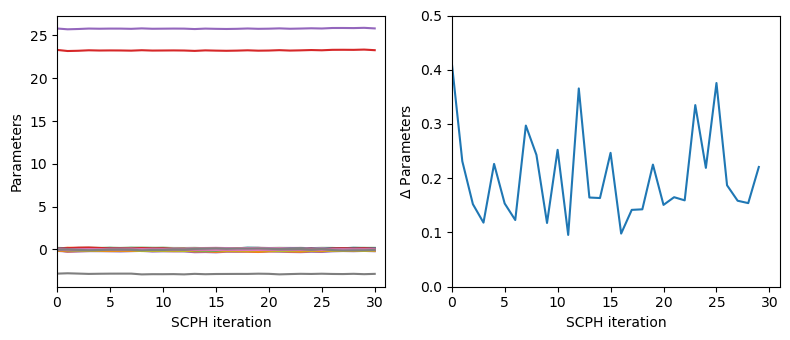

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from hiphive import ForceConstantPotential
#from helpers import get_dispersion

# read parameter trajs
params_traj = np.loadtxt('scph_trajs_mp/scph_parameters_T510.0_V164.5')
delta_parameters = [np.linalg.norm(p-p2) for p, p2 in zip(params_traj, params_traj[1:])]

# set up plot
fig = plt.figure(figsize=(8, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# plot scph convergence
ax1.plot(params_traj)
ax1.set_xlabel('SCPH iteration')
ax1.set_ylabel('Parameters')
ax1.set_xlim([0, len(params_traj)])

ax2.plot(delta_parameters)
ax2.set_xlabel('SCPH iteration')
ax2.set_ylabel('$\\Delta$ Parameters')
ax2.set_xlim([0, len(params_traj)])
ax2.set_ylim(bottom=0.0,top=0.5)

fig.tight_layout()
#fig.savefig('scph_parameter_convergence.svg')

### 4.3 Dispersion Functions

In [93]:
# import numpy as np
from ase import Atoms
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.units import THzToEv,THzToCm


def get_PA3_path(Nq=100):
    def get_path(q_start, q_stop, N):
        """ Return path between q_start and q_stop """
        return np.array([q_start + (q_stop-q_start) * i / (N - 1) for i in range(N)])

    G = np.array([0, 0, 0]); X = np.array([0.5, 0, 0]); M = np.array([0.5, 0.5, 0]); R = np.array([0.5, 0.5, 0.5])
    path = [get_path(G,X,Nq), get_path(X,M,Nq), get_path(M,G,Nq),get_path(G,R,Nq)]

    return path

def get_dispersion(fcp, size):
    # set up phonopy and get FCs
    prim = fcp.primitive_structure
    atoms_phonopy = PhonopyAtoms(symbols=prim.get_chemical_symbols(),
                                 scaled_positions=prim.get_scaled_positions(),
                                 cell=prim.cell)
    phonon = Phonopy(atoms_phonopy, supercell_matrix=size*np.eye(3),
                     primitive_matrix=None)
    supercell = Atoms(
        cell=phonon.supercell.cell,
        numbers=phonon.supercell.numbers,
        pbc=True,
        scaled_positions=phonon.supercell.get_scaled_positions())

    fcs = fcp.get_force_constants(supercell)
    phonon.force_constants = fcs.get_fc_array(order=2)

    # get phonon dispersion
    path = get_PA3_path()
    phonon.run_band_structure(path)
    qnorms = phonon.band_structure.distances
    freqs = phonon.band_structure.frequencies
    #freqs = [THzToEv * 1e3 * f for f in freqs]
    freqs = [THzToCm * f for f in freqs]
    return qnorms, freqs


### 4.4 Phonon Dispersion Analysis

#### 4.4.1 Single Example 

/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/site-packages/phonopy/structure/symmetry.py:328: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  "rotations": self._dataset["rotations"],


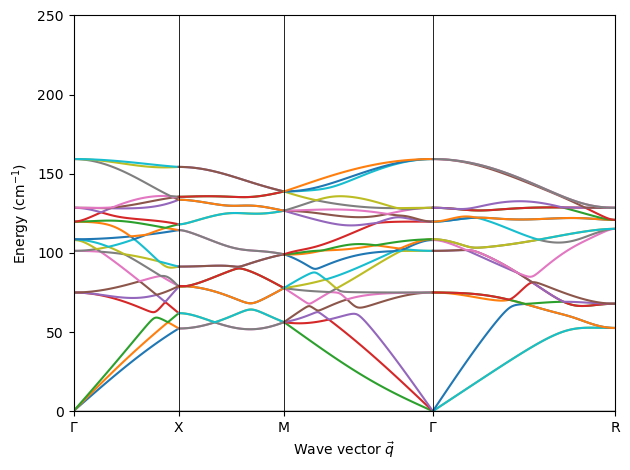

In [95]:
fcp_test = ForceConstantPotential.read(f'fcps_mp/scph_T30.0_V164.5.fcp')
dispersions_test = get_dispersion(fcp_test, 2)

qnorms, freqs = dispersions_test

# setup plot dispersions
fig = plt.figure()
ax1 = fig.add_subplot(111)

# plotting dispersion
for q, freq, in zip(qnorms, freqs):
    ax1.plot(q, freq)

ax1.set_xlabel(r'Wave vector $\vec{q}$')
ax1.set_ylabel('Energy (cm$^{-1}$)')
#ax1.legend()

# set qpts as x-ticks
qpts = [0] + [q[-1] for q in qnorms]
qpts_names = [r'$\Gamma$', 'X', 'M', r'$\Gamma$','R']
for q in qpts:
    ax1.axvline(q, color='k', lw=0.6)
ax1.axhline(y=0.0, color='k', ls='-', lw=1.0)
ax1.set_xticks(qpts)
ax1.set_xticklabels(qpts_names)
ax1.set_xlim([qpts[0], qpts[-1]])
ax1.set_ylim([0, 250])

fig.tight_layout()

#### 4.4.2 Load all Data

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from hiphive import ForceConstantPotential
#from helpers import get_dispersion

# read fcps
fcps = dict()
for V in volumes: 
    ttt = dict()
    for T in temperatures:
        # if T<1e-5:
        #     T=1e-5
        ttt[T] = ForceConstantPotential.read(f'fcps_mp/scph_T{T}_V{V:.1f}.fcp')
    fcps[V] = ttt


#### 4.4.3 Plot Volume Dispersions 

/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/site-packages/phonopy/structure/symmetry.py:328: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  "rotations": self._dataset["rotations"],


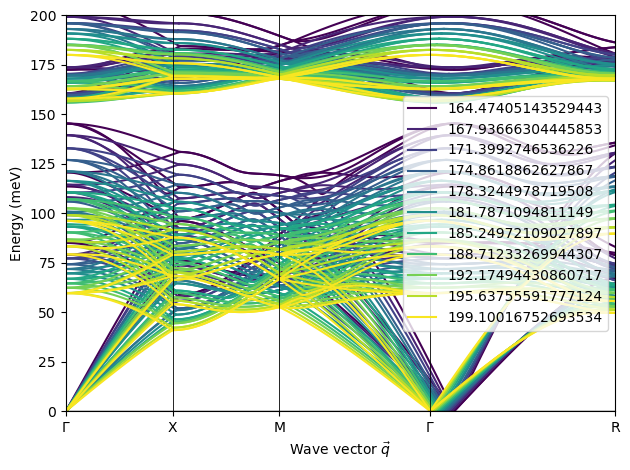

In [156]:

# collect dispersion
dispersions_volumes = dict()
temp = 300.0
for V, fcps_temp in fcps.items():
    dispersions_volumes[V] = get_dispersion(fcps_temp[temp], 2)

        
# setup plot dispersions
fig = plt.figure()
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap('viridis')
colors = {V: cmap(i/(len(dispersions_volumes)-0.9)) for i, V in enumerate(volumes)}

# plotting dispersion
for V, (qnorms, freqs) in dispersions_volumes.items():
    color = colors[V]
    for q, freq, in zip(qnorms, freqs):
        ax1.plot(q, freq, color=color)
    ax1.plot(np.nan, np.nan, color=color, label=f'{V}')

ax1.set_xlabel(r'Wave vector $\vec{q}$')
ax1.set_ylabel('Energy (meV)')
ax1.legend()

# set qpts as x-ticks
qpts = [0] + [q[-1] for q in qnorms]
qpts_names = [r'$\Gamma$', 'X', 'M', r'$\Gamma$','R']
for q in qpts:
    ax1.axvline(q, color='k', lw=0.6)
ax1.axhline(y=0.0, color='k', ls='-', lw=1.0)
ax1.set_xticks(qpts)
ax1.set_xticklabels(qpts_names)
ax1.set_xlim([qpts[0], qpts[-1]])
ax1.set_ylim([0, 200])

fig.tight_layout()
#fig.savefig('scph_phonon_dispersions.svg')


#### 4.4.3 Plot Temperature Dispersions 

/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/site-packages/phonopy/structure/symmetry.py:328: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  "rotations": self._dataset["rotations"],


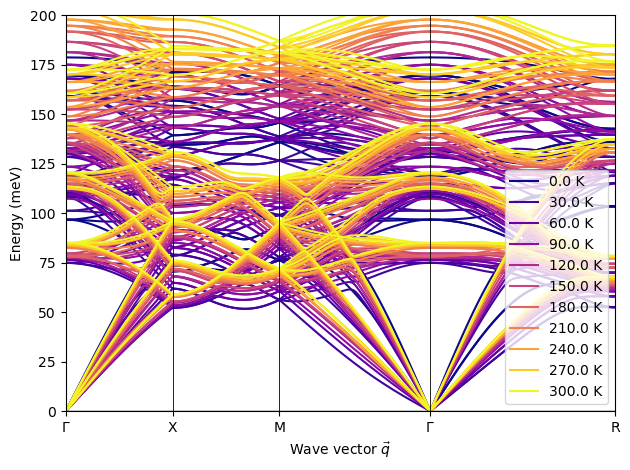

In [158]:

#collect dispersion
dispersions_temperatures = dict()
for T, fcp in fcps[volumes[0]].items():
    dispersions_temperatures[T] = get_dispersion(fcp, 2)


# setup plot dispersions
fig = plt.figure()
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap('plasma')
colors = {T: cmap(i/(len(dispersions_temperatures)-0.9)) for i, T in enumerate(temperatures)}

# plotting dispersion
for T, (qnorms, freqs) in dispersions_temperatures.items():
    if T==1e-5:
        # continue
        T=0.0
    color = colors[T]
    for q, freq, in zip(qnorms, freqs):
        ax1.plot(q, freq, color=color)
    ax1.plot(np.nan, np.nan, color=color, label=f'{T} K')

ax1.set_xlabel(r'Wave vector $\vec{q}$')
ax1.set_ylabel('Energy (meV)')
ax1.legend()

# set qpts as x-ticks
qpts = [0] + [q[-1] for q in qnorms]
qpts_names = [r'$\Gamma$', 'X', 'M', r'$\Gamma$','R']
for q in qpts:
    ax1.axvline(q, color='k', lw=0.6)
ax1.axhline(y=0.0, color='k', ls='-', lw=1.0)
ax1.set_xticks(qpts)
ax1.set_xticklabels(qpts_names)
ax1.set_xlim([qpts[0], qpts[-1]])
ax1.set_ylim([0, 200])

fig.tight_layout()
#fig.savefig('scph_phonon_dispersions.svg')

In [11]:
import importlib
import utils_scph
importlib.reload(utils_scph)
from utils_scph import self_consistent_harmonic_model_enhanced

## 5. Thermodynamic Properties 

### 5.1 SCPH Thermodynamic Properties

In [98]:
temperatures = np.arange(T_MIN, 510 + 1e-9, T_STEP)
print(temperatures)
print(volumes)

[  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330. 360. 390.
 420. 450. 480. 510.]
[164.47405144 167.93666304 171.39927465 174.86188626 178.32449787
 181.78710948 185.24972109 188.7123327  192.17494431 195.63755592
 199.10016753]


In [ ]:
import os, importlib
import numpy as np
from copy import deepcopy
from hiphive import ClusterSpace, ForceConstantPotential
from hiphive.calculators import ForceConstantCalculator


import phonopy
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms


def get_thermal(T, V, supercell):

    fcp = ForceConstantPotential.read(f'fcps_mp/scph_T{T}_V{V:.1f}.fcp')
    
    # set up phonopy and get FCs
    prim = fcp.primitive_structure
    atoms_phonopy = PhonopyAtoms(symbols=prim.get_chemical_symbols(),
                                 scaled_positions=prim.get_scaled_positions(),
                                 cell=prim.cell)
    
    ph = Phonopy(atoms_phonopy, supercell_matrix=supercell,
                     primitive_matrix=None)

    # FC2 from FCP on phonopy's supercell shape
    ase_sup = Atoms(cell=ph.supercell.cell,
                    numbers=ph.supercell.numbers, pbc=True,
                    scaled_positions=ph.supercell.scaled_positions)
    
    fcs = fcp.get_force_constants(ase_sup)
    ph.force_constants = fcs.get_fc_array(order=2)

    ph.run_mesh(MESH, is_gamma_center=True)
    ph.run_thermal_properties(t_min=T, t_max=T, t_step=1)
    tp = ph.get_thermal_properties_dict()

    return tp

Fv = []
Cv = []
Sv = []

Fv = np.empty([len(temperatures), len(volumes)])
Cv = np.empty([len(temperatures), len(volumes)])
Sv = np.empty([len(temperatures), len(volumes)])


# Calculate the total number of iterations
total_iterations = len(temperatures) * len(volumes)

# Initialize a single tqdm bar
with tqdm(total=total_iterations, desc="Overall Progress") as pbar: 
    for Vindex,V in enumerate(volumes):
        for Tindex,T in enumerate(temperatures):
            #if T<1e-5:
            #    T=30.0

            tp_scph = get_thermal(T, V, SUPER)

            Fv[Tindex,Vindex] = tp_scph['free_energy'][0]
            Cv[Tindex,Vindex] = tp_scph['entropy'][0]
            Sv[Tindex,Vindex] = tp_scph['heat_capacity'][0]

            pbar.update(1)
            # print(tp_scph)


Overall Progress:   0%|          | 0/198 [00:00<?, ?it/s]

/Users/osode/opt/miniconda3/envs/phonopy/lib/python3.12/site-packages/phonopy/structure/symmetry.py:328: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  "rotations": self._dataset["rotations"],


#          T           E_0           B_0          B'_0           V_0
      0.000000      0.392861      6.513799      5.524765    177.233619
     30.000000      0.365507      6.818383      8.909194    177.506870
     60.000000      0.356498      6.469942      8.315473    178.614609
     90.000000      0.331817      6.015634      7.528837    180.520296
    120.000000      0.292513      5.961667      8.370304    181.918691
    150.000000      0.245467      5.301131     10.111241    183.175072
    180.000000      0.187100      4.785764     10.083141    185.449068
    210.000000      0.121878      4.704032     10.602691    186.938053
    240.000000      0.050184      4.539111      8.896304    188.972366
    270.000000     -0.027311      3.440551     11.617660    192.057905
    300.000000     -0.110225      4.031844      8.135207    193.059372
    330.000000     -0.199389      4.962201      6.382808    193.057045
    360.000000     -0.293456      3.200160     10.918373    196.730027
    390.

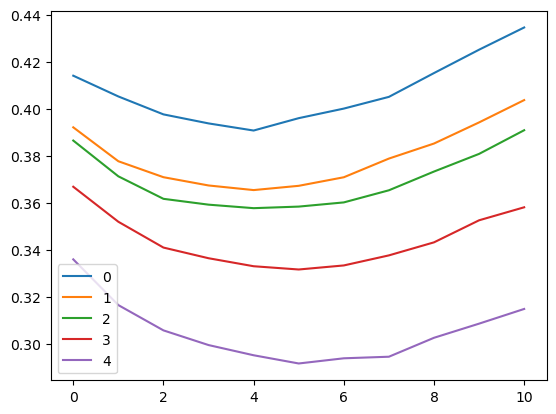

In [ ]:

Fvib_kJmol_scph = np.asarray(Fv)
Cv_J_scph = np.asarray(Cv)
Svib_J_scph = np.asarray(Sv)

sorted_vp = sorted(vp, key=lambda x: x['volume'])

E_elec_1d = np.array([vpt["thermal"]["E_elec_eV"] for vpt in sorted_vp], float)

qha_scph = QHA(
    volumes=[float(v) for v in volumes],
    electronic_energies=E_elec_1d,
    temperatures=[float(T) for T in temperatures],
    free_energy=Fvib_kJmol_scph,
    cv=Cv_J_scph,
    entropy=Svib_J_scph,
    eos=EOS,
    pressure=0.0,
    energy_plot_factor=1.0/96.48533212331002,
    verbose=True,
)

import matplotlib.pyplot as plt
for i in range(len(Fvib_kJmol_scph)):
    if i>4:
        continue
    plt.plot(E_elec_1d+Fvib_kJmol_scph[i]/96.48533212331002, label = i)
    plt.legend()



In [ ]:

print(qha_scph_orig._qha._equiv_volumes)
print(qha_scph_orig._qha._equiv_energies)

[177.23361869 177.50687045 178.61460903 180.52029581 181.91869061
 183.17507192 185.44906815 186.93805263 188.97236559 192.05790478
 193.05937188 193.05704494 196.7300269  199.87936467 205.37465773
 202.48594996 214.57309296 208.50616651]
[ 0.39286107  0.36550704  0.35649767  0.33181671  0.29251286  0.24546736
  0.18710041  0.12187779  0.05018424 -0.02731053 -0.11022459 -0.1993887
 -0.2934557  -0.3922688  -0.49868914 -0.60110829 -0.71912642 -0.82937293]


In [143]:

E_elec_1d = np.array([vp["thermal"]["E_elec_eV"] for vp in sorted_vp], float)
Fvib_kJmol = np.stack([vp["thermal"]["free_energy_kJmol"] for vp in sorted_vp], axis=1)  # (nT, nV)
Cv_J = np.stack([vp["thermal"]["cv_JmolK"] for vp in sorted_vp], axis=1)
Svib_J = np.stack([vp["thermal"]["s_JmolK"] for vp in sorted_vp], axis=1)


qha = QHA(
    volumes=[float(v) for v in volumes],
    electronic_energies=E_elec_1d,
    temperatures=[float(T) for T in temperatures],
    free_energy=Fvib_kJmol,
    cv=Cv_J,
    entropy=Svib_J,
    eos=EOS,
    pressure=0.0,
    energy_plot_factor=1.0/96.48533212331002,
    verbose=True,
)


#          T           E_0           B_0          B'_0           V_0
      0.000000      0.354700      6.791625      7.723551    178.864263
     30.000000      0.351952      6.584774      7.943736    179.284103
     60.000000      0.331033      5.832695      8.411874    181.399607
     90.000000      0.288742      4.894428      8.943068    184.773865
    120.000000      0.228263      3.854208      9.597428    189.400837
    150.000000      0.151560      2.727053     10.456390    195.987630
    180.000000      0.058623      1.531754     11.705226    206.838195
    210.000000     -0.054348      0.382012     14.039865    233.899423
    240.000000     -0.185706      0.037813     15.473783    297.947939
    270.000000     -0.322612      0.042660     13.456118    318.592788
    300.000000     -0.470144      0.063110     11.617332    329.598531
    330.000000     -0.627780      0.096048     10.079259    336.500737
    360.000000     -0.798167      0.111565      9.068573    352.196884
    390.

In [150]:

print(qha._qha._equiv_volumes)
print(qha._qha._equiv_energies)

[178.86426287 179.2841026  181.39960665 184.77386464 189.4008374
 195.98763002 206.83819518 233.89942289 297.94793872 318.59278831
 329.59853083 336.5007372  352.19688446 349.19577745 234.45843393
 366.8760466  367.58983829 252.91006933]
[ 0.35469987  0.35195191  0.33103344  0.28874195  0.22826276  0.15155974
  0.05862302 -0.05434806 -0.18570572 -0.32261187 -0.47014433 -0.62777953
 -0.79816687 -0.97251774 -1.02062303 -1.35713496 -1.55760648 -1.58041104]


#### Bootstrapping

In [ ]:
Fvib_kJmol_scph = np.asarray(Fv)
Cv_J_scph = np.asarray(Cv)
Svib_J_scph = np.asarray(Sv)

Fvib_kJmol = np.stack([vp["thermal"]["free_energy_kJmol"] for vp in volume_points], axis=1)  # (nT, nV)
Cv_J = np.stack([vp["thermal"]["cv_JmolK"] for vp in volume_points], axis=1)
Svib_J = np.stack([vp["thermal"]["s_JmolK"] for vp in volume_points], axis=1)

qha_scph_list = []
qha_norm_list = []

for Vindex,V in enumerate(volumes):
    
    F_scph = np.delete(Fvib_kJmol_scph, Vindex, axis=1)
    C_scph = np.delete(Cv_J_scph, Vindex, axis=1)
    S_scph = np.delete(Svib_J_scph, Vindex, axis=1)
    E_scph = np.delete(E_elec_1d, Vindex)
    
    F_norm = np.delete(Fvib_kJmol, Vindex, axis=1)
    C_norm = np.delete(Cv_J, Vindex, axis=1)
    S_norm = np.delete(Svib_J, Vindex, axis=1)
    E_norm = np.delete(E_elec_1d, Vindex)
    
    Vols = np.delete(volumes, Vindex)
    
    qha_scph = QHA(
        volumes=Vols,
        electronic_energies=E_scph,
        temperatures=[float(T) for T in temperatures],
        free_energy=F_scph,
        cv=C_scph,
        entropy=S_scph,
        eos=EOS,
        pressure=0.0,
        energy_plot_factor=1.0/96.48533212331002,
        verbose=True,
    )
    
    qha_norm = QHA(
        volumes=Vols,
        electronic_energies=E_norm,
        temperatures=[float(T) for T in temperatures],
        free_energy=F_norm,
        cv=C_norm,
        entropy=S_norm,
        eos=EOS,
        pressure=0.0,
        energy_plot_factor=1.0/96.48533212331002,
        verbose=True,
    )
    
    
    qha_scph_list.append(qha_scph)
    qha_norm_list.append(qha_norm)


#          T           E_0           B_0          B'_0           V_0
      0.000000      0.364796      6.739155      7.125911    177.923753
     30.000000      0.364796      6.739155      7.125911    177.923753
     60.000000      0.356188      6.502656      8.303578    178.650847
     90.000000      0.330858      6.402983     10.505209    179.770249
    120.000000      0.292413      5.902475      9.473446    181.713684
    150.000000      0.243967      5.502829      9.213369    183.569528
    180.000000      0.186737      5.213151      8.348815    185.299814
    210.000000      0.122077      4.704144      8.577059    187.399749
    240.000000      0.050230      4.739191      6.749715    189.518468
    270.000000     -0.027527      4.556929      7.020202    191.113522
    300.000000     -0.110895      3.160608     13.031489    193.388064
#          T           E_0           B_0          B'_0           V_0
      0.000000      0.355737      6.431167      6.531375    178.852120
     30.00

In [ ]:
G_norm_lovo  = []
G_scph_lovo  = []
V_norm_lovo  = []
V_scph_lovo  = []

for i in range(len(volumes)):
    # for T in Temperatures: 
    G_norm_lovo.append(qha_norm_list[i]._qha._equiv_energies)
    G_scph_lovo.append(qha_scph_list[i]._qha._equiv_energies)
    V_norm_lovo.append(qha_norm_list[i]._qha._equiv_volumes)
    V_scph_lovo.append(qha_scph_list[i]._qha._equiv_volumes)
    
G_norm_lovo = np.array(G_norm_lovo)
G_scph_lovo = np.array(G_scph_lovo)
V_norm_lovo = np.array(V_norm_lovo)
V_scph_lovo = np.array(V_scph_lovo)

In [ ]:
G_norm_lovo = np.stack(G_norm_lovo)
G_scph_lovo = np.stack(G_scph_lovo)
V_norm_lovo = np.stack(V_norm_lovo)
V_scph_lovo = np.stack(V_scph_lovo)

In [ ]:
G_norm_mean  = G_norm_lovo.mean(0); G_norm_std = G_norm_lovo.std(0, ddof=1)
G_scph_mean  = G_scph_lovo.mean(0); G_scph_std = G_scph_lovo.std(0, ddof=1)

V_norm_mean  = V_norm_lovo.mean(0); V_norm_std = V_norm_lovo.std(0, ddof=1)
V_scph_mean  = V_scph_lovo.mean(0); V_scph_std = V_scph_lovo.std(0, ddof=1)

dG_lovo = G_scph_lovo - G_norm_lovo
dG_mean = dG_lovo.mean(0); dG_std = dG_lovo.std(0, ddof=1)

dV_lovo = V_scph_lovo - V_norm_lovo
dV_mean = dV_lovo.mean(0); dV_std = dV_lovo.std(0, ddof=1)

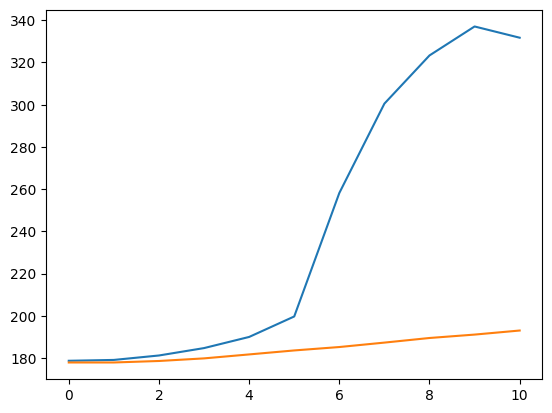

In [ ]:
plt.plot(V_norm_mean)
plt.plot(V_scph_mean)

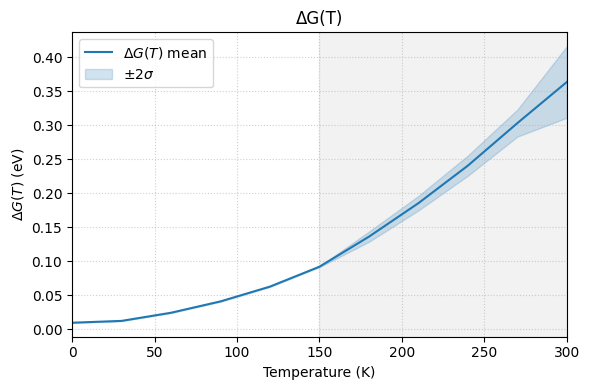

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))

# Main curve
ax.plot(temperatures[:], dG_mean, color="C0", label=r"$\Delta G(T)$ mean")

#ax.axvspan(150, 270, alpha=0.1, color="grey", label="SCPH hardening")
ax.axvspan(150, 300, alpha=0.1, color="grey")
ax.margins(x=0.00, y=0.05) 
# Shaded ±1σ band
ax.fill_between(
    temperatures[:],
    dG_mean - 2*dG_std,
    dG_mean + 2*dG_std,
    color="C0",
    alpha=0.2,
    label=r"$\pm 2\sigma$"
)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel(r"$\Delta G(T)$ (eV)")   # adjust units
ax.set_title(r"ΔG(T)")
ax.legend()
ax.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.savefig("Delta_GT.png", dpi=300, bbox_inches="tight")
plt.show()

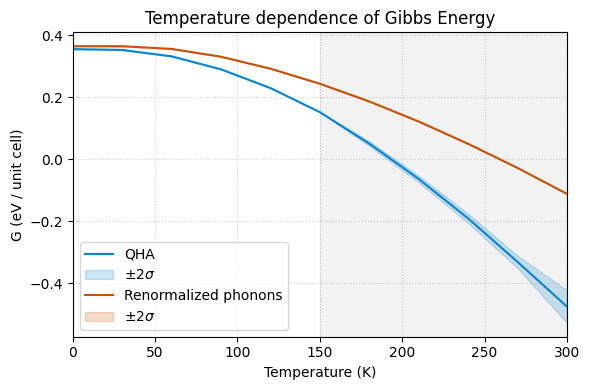

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(temperatures[:], G_norm_mean,  color="xkcd:cerulean", label="QHA")
ax.fill_between(temperatures[:], G_norm_mean - 2*G_norm_std, G_norm_mean + 2*G_norm_std,
                color="xkcd:cerulean", alpha=0.2, label=r"$\pm 2\sigma$")

ax.plot(temperatures[:], G_scph_mean, color="xkcd:dark orange", label="Renormalized phonons")
ax.fill_between(temperatures[:], G_scph_mean - 2*G_scph_std, G_scph_mean + 2*G_scph_std,
                color="xkcd:dark orange", alpha=0.2, label=r"$\pm 2\sigma$")
# Optional: mark hardening region
#ax.axvspan(150, 270, color="grey", alpha=0.1, label="SCPH hardening")
ax.axvspan(150, 300, color="grey", alpha=0.1, )

ax.margins(x=0.00, y=0.05) 
# Axes & title
ax.set_xlabel("Temperature (K)")
ax.set_ylabel(r"G (eV / unit cell)")  # adjust units
ax.set_title(r"Temperature dependence of Gibbs Energy")

ax.legend(frameon=True)
ax.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.savefig("G_T.png", dpi=300, bbox_inches="tight")
plt.show()



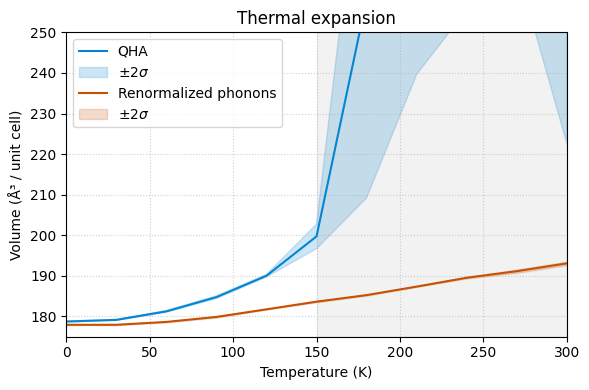

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(temperatures[:], V_norm_mean,  color="xkcd:cerulean", label="QHA")
ax.fill_between(temperatures[:], V_norm_mean - 2*V_norm_std, V_norm_mean + 2*V_norm_std,
                color="xkcd:cerulean", alpha=0.2, label=r"$\pm 2\sigma$" )

ax.plot(temperatures[:], V_scph_mean, color="xkcd:dark orange", label="Renormalized phonons")
ax.fill_between(temperatures[:], V_scph_mean - 2*V_scph_std, V_scph_mean + 2*V_scph_std,
                color="xkcd:dark orange", alpha=0.2, label=r"$\pm 2\sigma$")
# Optional: mark hardening region
#ax.axvspan(150, 270, color="grey", alpha=0.1, label="SCPH hardening")
ax.axvspan(150, 300, color="grey", alpha=0.1, )

# Axes & title
ax.set_xlabel("Temperature (K)")
ax.set_ylabel(r"Volume (Å³ / unit cell)")  # adjust units
ax.set_title(r"Thermal expansion")

ax.set_ylim(175,250)
ax.legend(frameon=True)
ax.margins(x=0.00, y=0.05) 
ax.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.savefig("Thermalexpansion.png", dpi=300, bbox_inches="tight")
plt.show()
